In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Modeling_and_Society

Mounted at /content/gdrive
/content/gdrive/MyDrive/Modeling_and_Society


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
energy_data = pd.read_csv('energy_dataset.csv.txt')
energy_data

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [5]:
#print(energy_data.info())
#print(energy_data.describe())

In [6]:
#energy_data.nunique()

In [7]:
energy_data.duplicated().value_counts()

False    35064
Name: count, dtype: int64

In [8]:
#using boxplots to look for outliers - none for this column
#plt.boxplot(energy_data["total load forecast"])

In [9]:
#plt.boxplot(energy_data["price day ahead"])

In [10]:
#plt.boxplot(energy_data["price actual"])

In [11]:
#energy_data_mat = energy_data.drop('time', axis=1)
#mat = energy_data_mat.corr()
#plt.figure(figsize=(20, 20))
#sns.heatmap(mat, annot=True)
#initial correlation matrix has a lot of gaps due to columns that are all zeros

In [12]:
# new df that drops a lot of stuff thats just zeros everywhere (it makes the heatmap look nicer and I assume we won;t be using these values anyway)
energy_data_cleaned = energy_data.drop(['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead' ], axis=1)
energy_data_cleaned_mat = energy_data_cleaned.drop('time', axis=1)

In [13]:
#mat = energy_data_cleaned_mat.corr()
#plt.figure(figsize=(20, 20))
#sns.heatmap(mat, annot=True)

In [14]:
#print(energy_data_cleaned.describe())

In [15]:
#adding a time increment column - ech row assigned a unique, incrementing number - can be used for change over time, subsetting dataframe
energy_data_cleaned_time_columns = energy_data_cleaned
energy_data_cleaned_time_columns['time increment'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    energy_data_cleaned_time_columns['time increment'][ind] = ind
#energy_data_cleaned_time_columns.tail()

In [16]:
#cleans up time column a bit - eliminates information useless to us
for ind in energy_data_cleaned_time_columns.index:
    energy_data_cleaned_time_columns['time'][ind] = energy_data_cleaned_time_columns['time'][ind][0:16]
#energy_data_cleaned_time_columns.tail()

In [17]:
# adds a column containing 1 if row is at midnight, 0 if not - can be used for subsetting graph to find changes in different times of day
# proof of concept, can create others based on this
energy_data_cleaned_time_columns['midnight'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time increment'][ind] % 24 == 0:
       energy_data_cleaned_time_columns['midnight'][ind] = 1
    else:
       energy_data_cleaned_time_columns['midnight'][ind] = 0
#commenting out this line to save space, but it shows proof that this code works
#energy_data_cleaned_time_columns.head(26)

In [18]:
# adds a column containing 1 if row is in January, 0 if not - can be used for subsetting graph to find changes between months - could also use to create columns for seasons
# proof of concept, can create others based on this
energy_data_cleaned_time_columns['January'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '01':
       energy_data_cleaned_time_columns['January'][ind] = 1
    else:
       energy_data_cleaned_time_columns['January'][ind] = 0
#energy_data_cleaned_time_columns.head()

In [19]:
energy_data_cleaned_time_columns['February'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '02':
       energy_data_cleaned_time_columns['February'][ind] = 1
    else:
       energy_data_cleaned_time_columns['February'][ind] = 0
#energy_data_cleaned_time_columns.head()

In [20]:
energy_data_cleaned_time_columns['December'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '12':
       energy_data_cleaned_time_columns['December'][ind] = 1
    else:
       energy_data_cleaned_time_columns['December'][ind] = 0
#energy_data_cleaned_time_columns.tail()

In [21]:
energy_data_cleaned_time_columns['March'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '03':
       energy_data_cleaned_time_columns['March'][ind] = 1
    else:
       energy_data_cleaned_time_columns['March'][ind] = 0

In [22]:
energy_data_cleaned_time_columns['April'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '04':
       energy_data_cleaned_time_columns['April'][ind] = 1
    else:
       energy_data_cleaned_time_columns['April'][ind] = 0

In [23]:
energy_data_cleaned_time_columns['May'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '05':
       energy_data_cleaned_time_columns['May'][ind] = 1
    else:
       energy_data_cleaned_time_columns['May'][ind] = 0

In [24]:
energy_data_cleaned_time_columns['June'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '06':
       energy_data_cleaned_time_columns['June'][ind] = 1
    else:
       energy_data_cleaned_time_columns['June'][ind] = 0

In [25]:
energy_data_cleaned_time_columns['July'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '07':
       energy_data_cleaned_time_columns['July'][ind] = 1
    else:
       energy_data_cleaned_time_columns['July'][ind] = 0

In [26]:
energy_data_cleaned_time_columns['August'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '08':
       energy_data_cleaned_time_columns['August'][ind] = 1
    else:
       energy_data_cleaned_time_columns['August'][ind] = 0

In [27]:
energy_data_cleaned_time_columns['September'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '09':
       energy_data_cleaned_time_columns['September'][ind] = 1
    else:
       energy_data_cleaned_time_columns['September'][ind] = 0

In [28]:
energy_data_cleaned_time_columns['October'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '10':
       energy_data_cleaned_time_columns['October'][ind] = 1
    else:
       energy_data_cleaned_time_columns['October'][ind] = 0

In [29]:
energy_data_cleaned_time_columns['November'] = np.nan
for ind in energy_data_cleaned_time_columns.index:
    if energy_data_cleaned_time_columns['time'][ind][5:7] == '11':
       energy_data_cleaned_time_columns['November'][ind] = 1
    else:
       energy_data_cleaned_time_columns['November'][ind] = 0

In [30]:
#remove some outliers from price actual

#find median
median = energy_data_cleaned_time_columns['price actual'].median()
print(median)

# Replace outliers with median value
energy_data_cleaned_time_columns.loc[energy_data_cleaned_time_columns['price actual'] > 90, 'price actual'] = median
energy_data_cleaned_time_columns.loc[energy_data_cleaned_time_columns['price actual'] < 20, 'price actual'] = median
#plt.boxplot(energy_data_cleaned_time_columns["price actual"])
#plt.show()

58.02


In [31]:
#find median
median = energy_data_cleaned_time_columns['total load actual'].median()
print(median)
energy_data_cleaned_time_columns['total load actual'].fillna(median, inplace=True)
#plt.boxplot(energy_data_cleaned_time_columns["total load actual"])
#plt.show()

28901.0


In [32]:
#tried two scatter plots with highest correlation, both do not seem to meet conditions of linear regression
#plt.figure(figsize=(20, 20))
#a, b = np.polyfit(energy_data_cleaned_time_columns['total load actual'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.xlabel("Actual Total Load on Grid")
#plt.ylabel("Actual Price")
#plt.title("Actual Total Load on Grid vs. Actual Price")
#plt.scatter(energy_data_cleaned_time_columns['total load actual'], energy_data_cleaned_time_columns['price actual'])
#plt.plot(energy_data_cleaned_time_columns['total load actual'], a*energy_data_cleaned_time_columns['total load actual']+b, color='red')

In [33]:
#plt.boxplot(energy_data_cleaned_time_columns["generation fossil hard coal"])

In [34]:
median = energy_data_cleaned_time_columns['generation fossil hard coal'].median()
print(median)
energy_data_cleaned_time_columns["generation fossil hard coal"].fillna(median, inplace=True)
energy_data_cleaned_time_columns.loc[energy_data_cleaned_time_columns['generation fossil hard coal'] > 15000, 'generation fossil hard coal'] = median
#plt.boxplot(energy_data_cleaned_time_columns["generation fossil hard coal"])

4474.0


In [35]:
#plt.figure(figsize=(20, 20))
a, b = np.polyfit(energy_data_cleaned_time_columns['generation fossil hard coal'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.scatter(energy_data_cleaned_time_columns['generation fossil hard coal'], energy_data_cleaned_time_columns['price actual'])
#plt.xlabel("Generation fossil hard coal")
#plt.ylabel("Actual Price")
#plt.title("Generation of Energy using Hard Coal vs. Actual Price")
#plt.plot(energy_data_cleaned_time_columns['generation fossil hard coal'], a*energy_data_cleaned_time_columns['generation fossil hard coal']+b, color='red')

In [36]:
#plt.figure(figsize=(20, 20))
#plt.xlabel("Generation of Energy using Nuclear")
#plt.ylabel("Actual Price")
#plt.title("Generation of Energy using Nuclear vs. Actual Price")
#plt.scatter(energy_data_cleaned_time_columns['generation nuclear'], energy_data_cleaned_time_columns['price actual'])


In [37]:
median = energy_data_cleaned_time_columns['generation solar'].median()
energy_data_cleaned_time_columns["generation solar"].fillna(median, inplace=True)
print(median)
#plt.boxplot(energy_data_cleaned_time_columns["generation solar"])

616.0


In [38]:
#plt.figure(figsize=(20, 20))
median = energy_data_cleaned_time_columns['generation solar'].median()
print(median)
energy_data_cleaned_time_columns["generation solar"].fillna(median, inplace=True)
a, b = np.polyfit(energy_data_cleaned_time_columns['generation solar'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.xlabel("Generation of Energy using Solar")
#plt.ylabel("Actual Price")
#plt.title("Generation of Energy using Solar vs. Actual Price")
#plt.scatter(energy_data_cleaned_time_columns['generation solar'], energy_data_cleaned_time_columns['price actual'])
#plt.plot(energy_data_cleaned_time_columns['generation solar'], a*energy_data_cleaned_time_columns['generation solar']+b, color='red')


616.0


In [39]:
median = energy_data_cleaned_time_columns['generation fossil gas'].median()
print(median)
energy_data_cleaned_time_columns["generation fossil gas"].fillna(median, inplace=True)
energy_data_cleaned_time_columns.loc[energy_data_cleaned_time_columns['generation fossil gas'] > 10500, 'generation fossil gas'] = median
energy_data_cleaned_time_columns.loc[energy_data_cleaned_time_columns['generation fossil gas'] < 500, 'generation fossil gas'] = median
#plt.boxplot(energy_data_cleaned_time_columns["generation fossil gas"])

4969.0


In [40]:
#plt.figure(figsize=(20, 20))
a, b = np.polyfit(energy_data_cleaned_time_columns['generation fossil gas'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.xlabel("Generation of Energy using Fossil Gas")
#plt.ylabel("Actual Price")
#plt.title("Generation of Energy using Fossil Gas vs. Actual Price")
#plt.scatter(energy_data_cleaned_time_columns['generation fossil gas'], energy_data_cleaned_time_columns['price actual'])
#plt.plot(energy_data_cleaned_time_columns['generation fossil gas'], a*energy_data_cleaned_time_columns['generation fossil gas']+b, color='red')

In [41]:
#plt.figure(figsize=(20, 20))
a, b = np.polyfit(energy_data_cleaned_time_columns['generation fossil hard coal'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.xlabel("Generation of Energy using Fossil Hard Coal")
#plt.ylabel("Actual Price")
#plt.title("Generation of Energy using Fossil Hard Coal vs. Actual Price")
#plt.scatter(energy_data_cleaned_time_columns['generation fossil hard coal'], energy_data_cleaned_time_columns['price actual'])
#plt.plot(energy_data_cleaned_time_columns['generation fossil hard coal'], a*energy_data_cleaned_time_columns['generation fossil hard coal']+b, color='red')

In [42]:
#plt.figure(figsize=(20, 20))
energy_data_cleaned_time_columns["generation wind onshore"].fillna(median, inplace=True)
a, b = np.polyfit(energy_data_cleaned_time_columns['generation wind onshore'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.xlabel("Generation of Energy using Onshore Wind")
#plt.ylabel("Actual Price")
#plt.title("Actual Price vs. Generation of Energy using Onshore Wind")
#plt.scatter(energy_data_cleaned_time_columns['generation wind onshore'], energy_data_cleaned_time_columns['price actual'])
#plt.plot(energy_data_cleaned_time_columns['generation wind onshore'], a*energy_data_cleaned_time_columns['generation wind onshore']+b, color='red')

In [43]:
median = energy_data_cleaned_time_columns['generation fossil oil'].median()
print(median)
energy_data_cleaned_time_columns["generation fossil oil"].fillna(median, inplace=True)
energy_data_cleaned_time_columns.loc[energy_data_cleaned_time_columns['generation fossil oil'] < 120, 'generation fossil oil'] = median
#plt.boxplot(energy_data_cleaned_time_columns["generation fossil oil"])

300.0


In [44]:
#plt.figure(figsize=(20, 20))
median = energy_data_cleaned_time_columns['generation fossil oil'].median()
print(median)
energy_data_cleaned_time_columns["generation fossil oil"].fillna(median, inplace=True)
a, b = np.polyfit(energy_data_cleaned_time_columns['generation fossil oil'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.xlabel("Generation of Energy using Fossil Oil")
#plt.ylabel("Actual Price")
#plt.title("Generation of Energy using Fossil Oil vs. Actual Price")
#plt.scatter(energy_data_cleaned_time_columns['generation fossil oil'], energy_data_cleaned_time_columns['price actual'])
#plt.plot(energy_data_cleaned_time_columns['generation fossil oil'], a*energy_data_cleaned_time_columns['generation fossil oil']+b, color='red')

300.0


In [45]:
#plt.figure(figsize=(20, 20))
energy_data_cleaned_time_columns["generation hydro pumped storage consumption"].fillna(median, inplace=True)
a, b = np.polyfit(energy_data_cleaned_time_columns['generation hydro pumped storage consumption'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.xlabel("Generation of Energy using Hydro Storage")
#plt.ylabel("Actual Price")
#plt.title("Generation of Energy using Hydro Storage vs. Actual Price")
#plt.scatter(energy_data_cleaned_time_columns['generation hydro pumped storage consumption'], energy_data_cleaned_time_columns['price actual'])
#plt.plot(energy_data_cleaned_time_columns['generation hydro pumped storage consumption'], a*energy_data_cleaned_time_columns['generation hydro pumped storage consumption']+b, color='red')

In [46]:
#plt.figure(figsize=(20, 20))
energy_data_cleaned_time_columns["generation hydro water reservoir"].fillna(median, inplace=True)
a, b = np.polyfit(energy_data_cleaned_time_columns['generation hydro water reservoir'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.xlabel("Generation of Energy using Water Reservoir")
#plt.ylabel("Actual Price")
#plt.title("Generation of Energy using Water Reservoir vs. Actual Price")
#plt.scatter(energy_data_cleaned_time_columns['generation hydro water reservoir'], energy_data_cleaned_time_columns['price actual'])
#plt.plot(energy_data_cleaned_time_columns['generation hydro water reservoir'], a*energy_data_cleaned_time_columns['generation hydro water reservoir']+b, color='red')

In [47]:
median = energy_data_cleaned_time_columns['generation hydro run-of-river and poundage'].median()
print(median)
energy_data_cleaned_time_columns["generation hydro run-of-river and poundage"].fillna(median, inplace=True)
#energy_data_cleaned_time_columns.loc[energy_data_cleaned_time_columns['generation fossil oil'] > 10500, 'generation fossil oil'] = median
#energy_data_cleaned_time_columns.loc[energy_data_cleaned_time_columns['generation fossil oil'] < 120, 'generation fossil oil'] = median
#plt.boxplot(energy_data_cleaned_time_columns["generation hydro run-of-river and poundage"])

906.0


In [48]:
#plt.figure(figsize=(20, 20))
a, b = np.polyfit(energy_data_cleaned_time_columns['generation hydro run-of-river and poundage'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.xlabel("Generation of Energy using run-of-river and poundage")
#plt.ylabel("Actual Price")
#plt.title("Generation of Energy using run-of-river and poundage vs. Actual Price")
#plt.scatter(energy_data_cleaned_time_columns['generation hydro run-of-river and poundage'], energy_data_cleaned_time_columns['price actual'])
#plt.plot(energy_data_cleaned_time_columns['generation hydro run-of-river and poundage'], a*energy_data_cleaned_time_columns['generation hydro run-of-river and poundage']+b, color='red')

In [49]:
#plt.figure(figsize=(20, 20))
energy_data_cleaned_time_columns["generation fossil brown coal/lignite"].fillna(median, inplace=True)
a, b = np.polyfit(energy_data_cleaned_time_columns['generation fossil brown coal/lignite'], energy_data_cleaned_time_columns['price actual'], 1)
#plt.xlabel("Generation of Energy using fossil brown coal/lignite")
#plt.ylabel("Actual Price")
#plt.title("Generation of Energy using fossil brown coal/lignite vs. Actual Price")
#plt.scatter(energy_data_cleaned_time_columns['generation fossil brown coal/lignite'], energy_data_cleaned_time_columns['price actual'])
#plt.plot(energy_data_cleaned_time_columns['generation fossil brown coal/lignite'], a*energy_data_cleaned_time_columns['generation fossil brown coal/lignite']+b, color='red')

In [50]:
#plt.boxplot(energy_data_cleaned_time_columns["generation wind onshore"])

In [51]:
median = energy_data_cleaned_time_columns['generation wind onshore'].median()
print(median)
energy_data_cleaned_time_columns.loc[energy_data_cleaned_time_columns['generation wind onshore'] > 15000, 'generation wind onshore'] = median
#plt.boxplot(energy_data_cleaned_time_columns["generation wind onshore"])

4850.5


In [52]:
#plt.boxplot(energy_data_cleaned_time_columns["generation hydro pumped storage consumption"])

In [53]:
median = energy_data_cleaned_time_columns['generation hydro pumped storage consumption'].median()
print(median)
energy_data_cleaned_time_columns.loc[energy_data_cleaned_time_columns['generation hydro pumped storage consumption'] > 2000, 'generation hydro pumped storage consumption'] = median
#plt.boxplot(energy_data_cleaned_time_columns["generation hydro pumped storage consumption"])

68.0


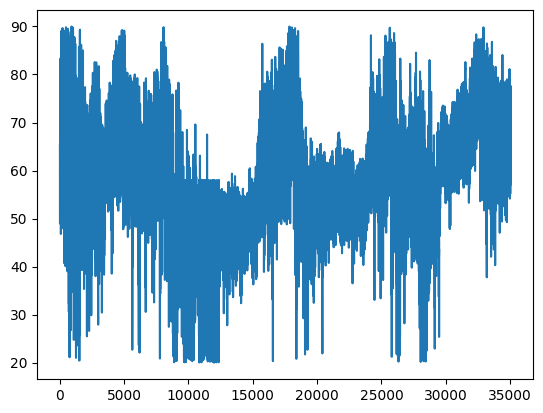

In [54]:
plt.plot(energy_data_cleaned_time_columns['time increment'], energy_data_cleaned_time_columns['price actual'])

In [55]:
#print(energy_data_cleaned_time_columns['generation solar'].describe())

In [56]:
#plt.boxplot(energy_data_cleaned_time_columns["generation solar"])

In [57]:
month_subset_df = energy_data_cleaned_time_columns[energy_data_cleaned_time_columns['December']==1]
X = month_subset_df.drop(['generation wind onshore', 'price actual', 'time', 'midnight', 'January', 'February', 'December', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'price day ahead', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual'], axis=1)
X = X.fillna(0) #acting on assumption that unrecorded values for generation where when nothing was being generated
X_partial_vif = X.drop(['generation other renewable','generation waste', 'generation fossil oil', 'generation biomass', 'generation nuclear'], axis=1)
#X = X.drop(['generation other', 'generation other renewable', 'generation biomass', 'generation waste', 'generation fossil oil', 'generation nuclear', 'generation fossil gas', 'generation fossil hard coal', 'generation hydro run-of-river and poundage'],axis=1)
 #had to drop a bunch due to high multicollinearity
vif = pd.DataFrame()
vif["variables"] = X.columns #VIF tests for multicollinearity, VIF > 5 is high multicollinearity
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                                      variables        VIF
0                            generation biomass  60.422540
1          generation fossil brown coal/lignite   7.975144
2                         generation fossil gas  19.831320
3                   generation fossil hard coal  22.405202
4                         generation fossil oil  48.764346
5   generation hydro pumped storage consumption   1.671745
6    generation hydro run-of-river and poundage  25.109895
7              generation hydro water reservoir   5.828768
8                            generation nuclear  60.679211
9                              generation other  26.317056
10                   generation other renewable  98.493046
11                             generation solar   1.543445
12                             generation waste  81.632037
13                               time increment  35.440188


In [58]:

y = month_subset_df["price actual"]
# instance of the StandardScaler
sc = StandardScaler()

# fit the scaler to the data
sc.fit(X)

# transform the data using the scaler
#X = sc.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
lm1 = sm.OLS(y_train, X_train).fit()
print(lm1.summary())
y_pred = lm1.predict(X_test)
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Error (MAE)
mae =mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

                            OLS Regression Results                            
Dep. Variable:           price actual   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     148.7
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          5.70e-300
Time:                        00:15:24   Log-Likelihood:                -7259.4
No. Observations:                2083   AIC:                         1.455e+04
Df Residuals:                    2068   BIC:                         1.463e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [59]:
#Combine columns into green/dirty -- This seems to consistently deliver worse results - R2 is lower and MSE is higher - not all energy sources of a similar "cleanliness" are created equal in terms of their cost
#X_combined = X
#X_combined['Green'] = X_combined['generation biomass'] + X_combined['generation hydro pumped storage consumption'] + X_combined['generation hydro run-of-river and poundage'] + X_combined['generation hydro water reservoir'] +  X_combined['generation nuclear'] + X_combined['generation other renewable'] + X_combined['generation solar']  + X_combined['generation wind onshore']
#X_combined['Dirty'] = X_combined['generation fossil brown coal/lignite'] + X_combined['generation fossil gas'] + X_combined['generation fossil hard coal'] + X_combined['generation fossil oil'] + X_combined['generation other']
#X_combined = X_combined[['Green', 'Dirty']]
#X_combined.head()
#X_combined_train, X_combined_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)
#X_combined_train = sm.add_constant(X_combined_train)
#X_combined_test = sm.add_constant(X_combined_test)
#lm1 = sm.OLS(y_train, X_combined_train).fit()
#print(lm1.summary())
#y_combined_pred = lm1.predict(X_combined_test)
#mse = mean_squared_error(y_test, y_combined_pred)
#print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
#rmse = np.sqrt(mse)
#print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Error (MAE)
#mae =mean_absolute_error(y_test, y_combined_pred)
#print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
#r2 = r2_score(y_test, y_combined_pred)
#print(f"R-squared (R²): {r2}")

In [60]:
# Attempt to take out only columns with most extreme VIF
vif = pd.DataFrame()
vif["variables"] = X_partial_vif.columns #VIF tests for multicollinearity, VIF > 5 is high multicollinearity
vif["VIF"] = [variance_inflation_factor(X_partial_vif.values, i) for i in range(X_partial_vif.shape[1])]
print(vif)
X_train, X_test, y_train, y_test = train_test_split(X_partial_vif, y, test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
lm1 = sm.OLS(y_train, X_train).fit()
print(lm1.summary())
y_pred = lm1.predict(X_test)
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Error (MAE)
mae =mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

                                     variables        VIF
0         generation fossil brown coal/lignite   7.450012
1                        generation fossil gas  18.378214
2                  generation fossil hard coal  17.174683
3  generation hydro pumped storage consumption   1.558547
4   generation hydro run-of-river and poundage  21.286714
5             generation hydro water reservoir   5.396733
6                             generation other  12.666250
7                             generation solar   1.527772
8                               time increment  12.177431
                            OLS Regression Results                            
Dep. Variable:           price actual   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     217.2
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          2.45e-291
Time:                    

In [61]:
ridge_model = Ridge(alpha=0.000000001)  # You can adjust the alpha value
ridge_model.fit(X_train, y_train)


# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Calculate mean squared error
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge Regression MSE: {mse_ridge:.2f}")
names = ["const", "generation biomass", "generation fossil brown coal/lignite ", "generation fossil gas", "generation fossil hard coal", "generation fossil oil", "generation hydro pumped storage consumption", "generation hydro run-of-river and poundage", "generation hydro water reservoir", "generation nuclear", "generation other",  "generation other renewable ", "generation solar", "generation waste", "generation wind onshore" ]
coef = ridge_model.coef_
print(coef)
#for i in range(15):
  #print(names[i], ": ", coef[i])
mse_lasso = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge Regression MSE: {mse_ridge:.2f}")
r2 = r2_score(y_test, y_pred_ridge)
print(f"R-squared (R²): {r2}")


Ridge Regression MSE: 68.32
[ 0.          0.00216639  0.00103795  0.00156203 -0.00169104  0.00080509
  0.00258772 -0.00900802  0.00139836  0.00017001]
Ridge Regression MSE: 68.32
R-squared (R²): 0.5083603828849341


In [62]:
from sklearn.linear_model import Lasso

# Create and fit a Lasso Regression model
lasso_model = Lasso(alpha=0.1)  # You can adjust the alpha value
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test)
coef = lasso_model.coef_
print(coef)
#for i in range(15):
  #print(names[i], ": ", coef[i])
# Calculate mean squared error
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso Regression MSE: {mse_lasso:.2f}")
r2 = r2_score(y_test, y_pred_lasso)
print(f"R-squared (R²): {r2}")

[ 0.          0.00216426  0.00103769  0.00156135 -0.00169091  0.00079732
  0.00258805 -0.00850777  0.00139824  0.00017044]
Lasso Regression MSE: 68.33
R-squared (R²): 0.5083185503040861


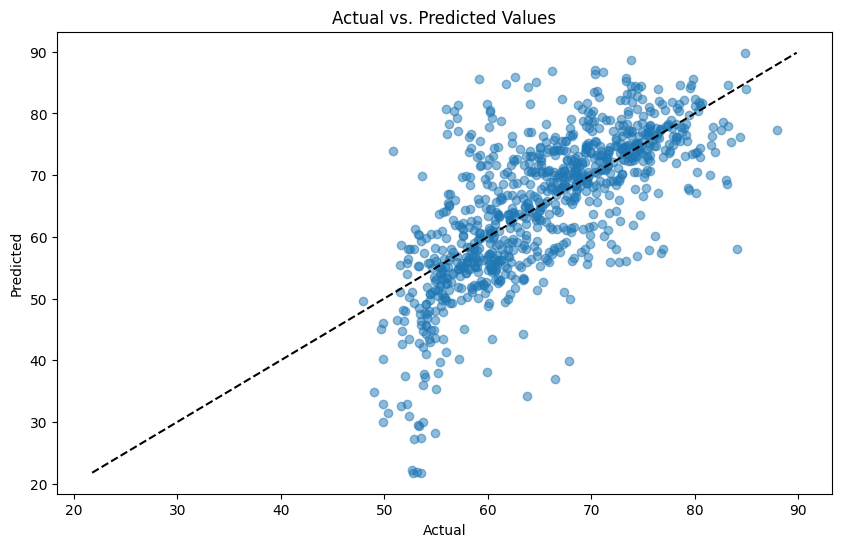

In [63]:
#y_pred = lm1.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ridge, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k') #plt.plt([x,y])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

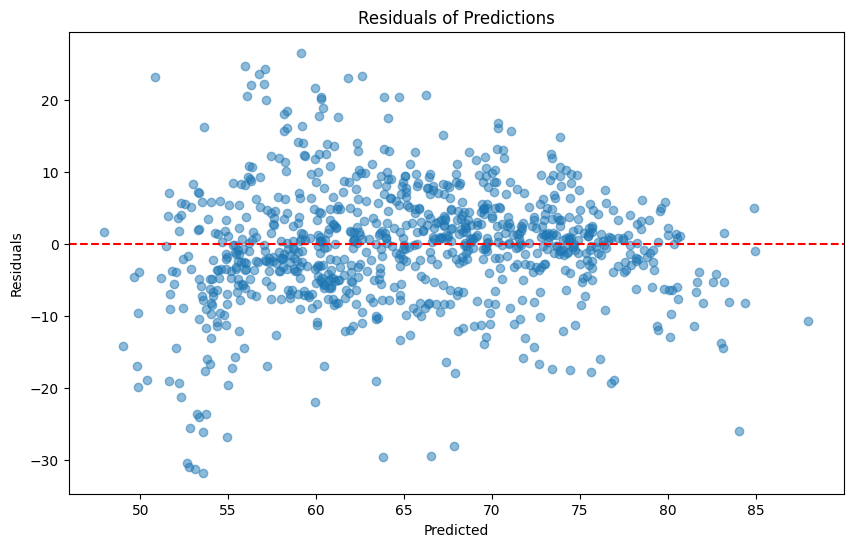

In [64]:
residuals = (y_test - y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha= 0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Adds a horizontal line at y=0
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

In [65]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Error (MAE)
mae =mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 68.32211583882646
Root Mean Squared Error (RMSE): 8.265719317689566
Mean Absolute Error (MAE): 6.015696586526611
R-squared (R²): 0.5083603828849341


In [66]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [67]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'])
print(loadings)

         PC1       PC2
0   0.005508  0.005121
1   0.005557  0.108117
2  -0.032536  0.606661
3   0.076787  0.728168
4   0.001944  0.009912
5   0.003676 -0.077334
6  -0.018966 -0.008652
7  -0.012265  0.276019
8   0.021291 -0.052594
9   0.000713  0.001343
10 -0.000847  0.001963
11 -0.000789  0.061826
12 -0.002855  0.006552
13 -0.995989  0.032260


Text(0, 0.5, 'Principal Component 2')

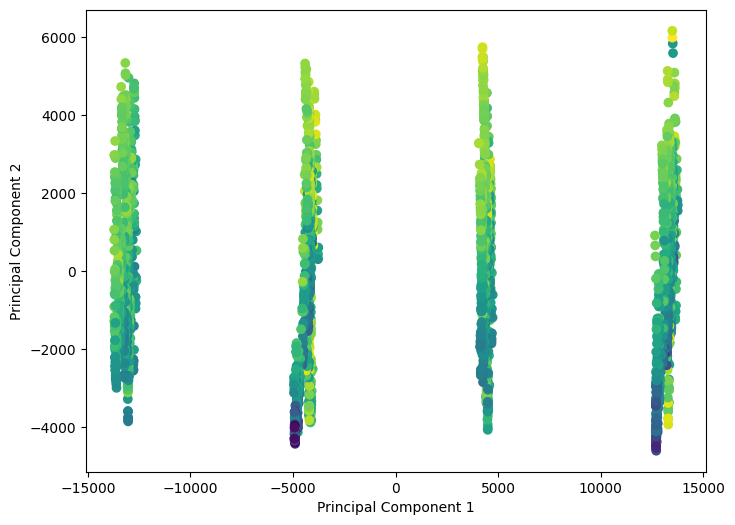

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [70]:
pca_model = LinearRegression()
pca_model.fit(X_pca, y)
y_pred = pca_model.predict(X_pca)
print(y_pred)
mse = mean_squared_error(y, y_pred)
print(mse)
#r2 = r2_score(y_test, y_pred)   not sure why this isn't working, not currently priority
#print(f"R-squared (R²): {r2}")

[64.63111649 62.60428849 60.81112865 ... 67.17246949 65.42454678
 65.49625553]
82.08342121244775


In [ ]:
data = pd.read_csv("energy_dataset.csv.txt")
data = data.drop(["time", "generation hydro pumped storage aggregated", "forecast solar day ahead", "forecast wind offshore eday ahead", "forecast wind onshore day ahead", "total load forecast", "total load actual", "price day ahead"], axis = 1)
median = data["generation biomass"].median()
data["generation biomass"].fillna(median, inplace = True)
median = data["generation fossil brown coal/lignite"].median()
data["generation fossil brown coal/lignite"].fillna(median, inplace = True)
median = data["generation fossil coal-derived gas"].median()
data["generation fossil coal-derived gas"].fillna(median, inplace = True)
median = data["generation fossil gas"].median()
data["generation fossil gas"].fillna(median, inplace = True)
median = data["generation fossil hard coal"].median()
data["generation fossil hard coal"].fillna(median, inplace = True)
median = data["generation fossil oil"].median()
data["generation fossil oil"].fillna(median, inplace = True)
median = data["generation fossil oil shale"].median()
data["generation fossil oil shale"].fillna(median, inplace = True)
median = data["generation fossil peat"].median()
data["generation fossil peat"].fillna(median, inplace = True)
median = data["generation geothermal"].median()
data["generation geothermal"].fillna(median, inplace = True)
median = data["generation hydro pumped storage consumption"].median()
data["generation hydro pumped storage consumption"].fillna(median, inplace = True)
median = data["generation hydro run-of-river and poundage"].median()
data["generation hydro run-of-river and poundage"].fillna(median, inplace = True)
median = data["generation hydro water reservoir"].median()
data["generation hydro water reservoir"].fillna(median, inplace = True)
median = data["generation marine"].median()
data["generation marine"].fillna(median, inplace = True)
median = data["generation nuclear"].median()
data["generation nuclear"].fillna(median, inplace = True)
median = data["generation other"].median()
data["generation other"].fillna(median, inplace = True)
median = data["generation other renewable"].median()
data["generation other renewable"].fillna(median, inplace = True)
median = data["generation solar"].median()
data["generation solar"].fillna(median, inplace = True)
median = data["generation waste"].median()
data["generation waste"].fillna(median, inplace = True)
median = data["generation wind offshore"].median()
data["generation wind offshore"].fillna(median, inplace = True)
median = data["generation wind onshore"].median()
data["generation wind onshore"].fillna(median, inplace = True)

data

In [73]:
X = data.drop("price actual", axis = 1)
y = data["price actual"]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [75]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [76]:
y_pred = regressor.predict(X_test)

In [77]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Mean Squared Error:  75.05713663368032
R^2 Score:  0.6303841028414723


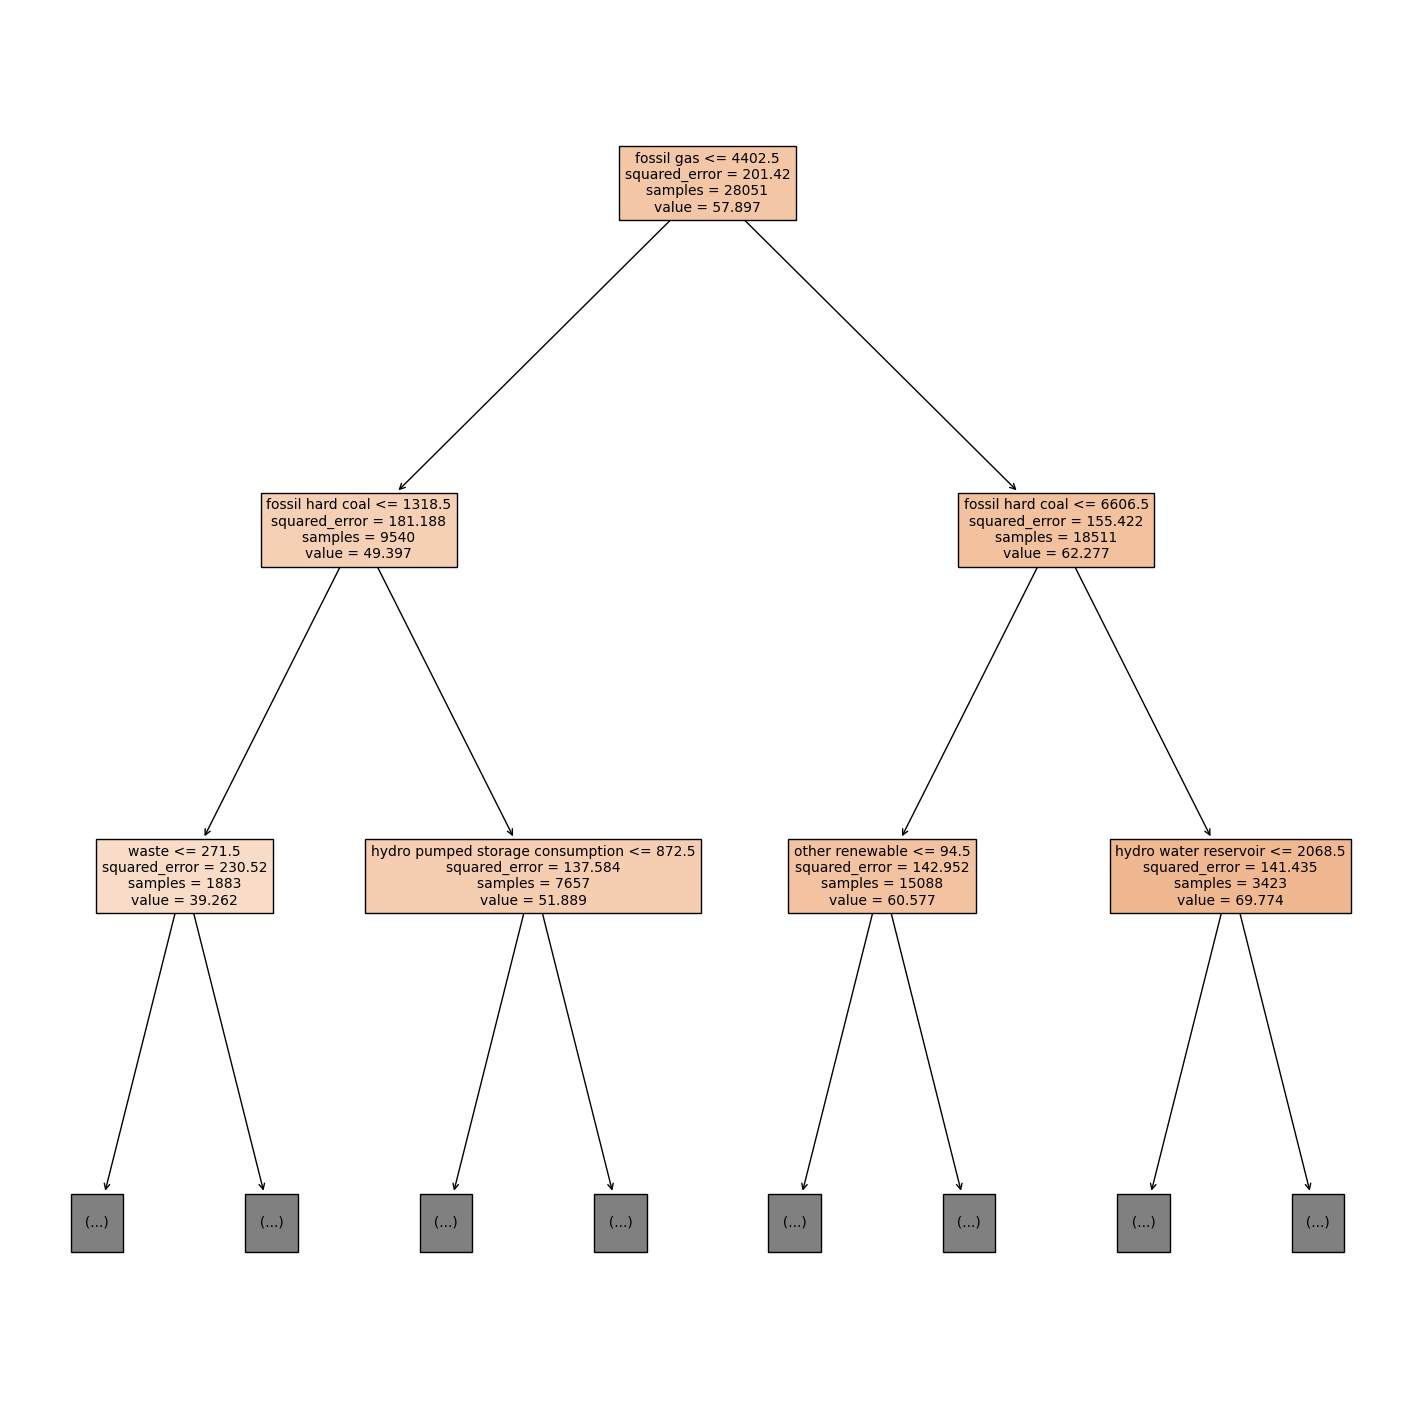

In [78]:
column_names = ["biomass", "fossil brown coal/lignite", "fossil coal-derived gas", "fossil gas","fossil hard coal", "fossil oil", "fossil oil shale", "fossil peat", "geothermal", "hydro pumped storage consumption", "hydro run-of-river poundage", "hydro water reservoir", "marine", "nuclear", "other", "other renewable", "solar", "waste", "wind offshore", "wind onshore"]
plt.figure(figsize=(18,18))
tree.plot_tree(regressor, filled = True, feature_names = column_names, max_depth = 2, fontsize=10)
plt.show()